<a href="https://colab.research.google.com/github/Struth-Rourke/DS-Unit-4-Sprint-2-Neural-Networks/blob/master/module4-Hyperparameter-Tuning/Lecture_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 4, Sprint 2, Module 4*

---

# Neural Networks & GPUs (Prepare)
*aka Hyperparameter Tuning*

*aka Big Servers for Big Problems*

## Learning Objectives
* <a href="#p1">Part 1</a>: Describe the major hyperparemeters to tune
* <a href="#p2">Part 2</a>: Implement an experiment tracking framework
* <a href="#p3">Part 3</a>: Search the hyperparameter space using RandomSearch (Optional)

In [1]:
!pip install wandb

     |████████████████████████████████| 1.4MB 3.5MB/s 
     |████████████████████████████████| 102kB 8.1MB/s 
     |████████████████████████████████| 460kB 16.3MB/s 
     |████████████████████████████████| 112kB 25.0MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
     |████████████████████████████████| 71kB 6.5MB/s 
  Created wheel for watchdog: filename=watchdog-0.10.2-cp36-none-any.whl size=73605 sha256=c39e5ab5bf508a10ba833e41a1ff0994abd454519221a429e00221829aaf4fe4
  Stored in directory: /root/.cache/pip/wheels/bc/ed/6c/028dea90d31b359cd2a7c8b0da4db80e41d24a59614154072e
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=3e99335381db0704c00daa4622b8e4df2f490b124b7e790f749f9261a6a64498
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=6288

In [2]:
!wandb login 65d45dd1157e5a7ff9c47b50f9026ad8ae4a51d7

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [0]:
wandb_group = "struth-rourke"
wandb_project = "hyperparameter_tuning"

# Hyperparameter Options (Learn)
<a id="p1"></a>

## Overview

Hyperparameter tuning is much more important with neural networks than it has been with any other models that we have considered up to this point. Other supervised learning models might have a couple of parameters, but neural networks can have dozens. These can substantially affect the accuracy of our models and although it can be a time consuming process is a necessary step when working with neural networks.
​
Hyperparameter tuning comes with a challenge. How can we compare models specified with different hyperparameters if our model's final error metric can vary somewhat erratically? How do we avoid just getting unlucky and selecting the wrong hyperparameter? This is a problem that to a certain degree we just have to live with as we test and test again. However, we can minimize it somewhat by pairing our experiments with Cross Validation to reduce the variance of our final accuracy values.

### Load Boston Housing Data

In [4]:
from tensorflow.keras.datasets import boston_housing

(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


### Normalizing Input Data

It's not 100% necessary to normalize/scale your input data before feeding it to a neural network, the network can learn the appropriate weights to deal with data of as long as it is numerically represented,  but it is recommended as it can help **make training faster** and **reduces the chances that gradient descent might get stuck in a local optimum**.

<https://stackoverflow.com/questions/4674623/why-do-we-have-to-normalize-the-input-for-an-artificial-neural-network>

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train[:10])

[[-0.27224633 -0.48361547 -0.43576161 -0.25683275 -0.1652266  -0.1764426
   0.81306188  0.1166983  -0.62624905 -0.59517003  1.14850044  0.44807713
   0.8252202 ]
 [-0.40342651  2.99178419 -1.33391162 -0.25683275 -1.21518188  1.89434613
  -1.91036058  1.24758524 -0.85646254 -0.34843254 -1.71818909  0.43190599
  -1.32920239]
 [ 0.1249402  -0.48361547  1.0283258  -0.25683275  0.62864202 -1.82968811
   1.11048828 -1.18743907  1.67588577  1.5652875   0.78447637  0.22061726
  -1.30850006]
 [-0.40149354 -0.48361547 -0.86940196 -0.25683275 -0.3615597  -0.3245576
  -1.23667187  1.10717989 -0.51114231 -1.094663    0.78447637  0.44807713
  -0.65292624]
 [-0.0056343  -0.48361547  1.0283258  -0.25683275  1.32861221  0.15364225
   0.69480801 -0.57857203  1.67588577  1.5652875   0.78447637  0.3898823
   0.26349695]
 [-0.37502238 -0.48361547 -0.54747912 -0.25683275 -0.54935658 -0.78865126
   0.18954148  0.48371503 -0.51114231 -0.71552978  0.51145832  0.38669063
  -0.13812828]
 [ 0.58963463 -0.48361547

### Model Validation using an automatic verification Dataset

Instead of doing seperate train test split class, Keras has a really nice feature that you can set the validation.data argument when fitting your model and Keras will take that portion of your test data and use it as a validation dataset. 

In [6]:
y_train.mean(), y_train.std()

(22.395049504950492, 9.199035423364862)

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Important Hyperparameters
inputs = X_train.shape[1]
epochs = 75
batch_size = 10


# Create Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(inputs,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit Model
results = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=epochs,
                    batch_size=batch_size
         )

Epoch 1/75
41/41 [==============================] - 0s 9ms/step - loss: 483.3296 - mae: 19.8160 - val_loss: 395.6707 - val_mae: 17.5216
Epoch 2/75
41/41 [==============================] - 0s 5ms/step - loss: 229.6687 - mae: 12.4901 - val_loss: 110.2444 - val_mae: 8.7581
Epoch 3/75
41/41 [==============================] - 0s 5ms/step - loss: 52.6195 - mae: 5.4464 - val_loss: 41.7908 - val_mae: 4.9674
Epoch 4/75
41/41 [==============================] - 0s 5ms/step - loss: 25.8575 - mae: 3.6007 - val_loss: 29.6289 - val_mae: 4.1092
Epoch 5/75
41/41 [==============================] - 0s 5ms/step - loss: 19.9344 - mae: 3.0942 - val_loss: 27.5777 - val_mae: 3.9079
Epoch 6/75
41/41 [==============================] - 0s 6ms/step - loss: 17.4919 - mae: 2.8845 - val_loss: 25.4061 - val_mae: 3.7317
Epoch 7/75
41/41 [==============================] - 0s 5ms/step - loss: 16.1849 - mae: 2.7957 - val_loss: 26.1255 - val_mae: 3.7197
Epoch 8/75
41/41 [==============================] - 0s 5ms/step - los

In [8]:
results.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


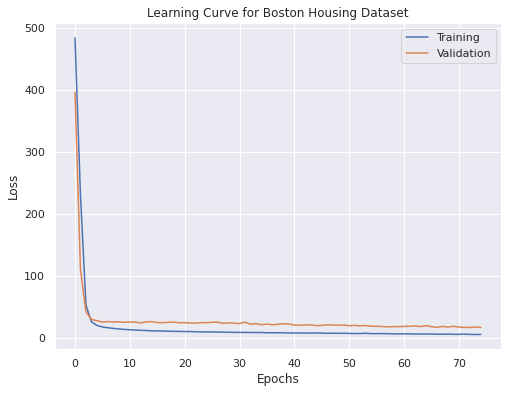

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(8,6))
plt.plot(results.history["loss"], label="Training")
plt.plot(results.history["val_loss"], label="Validation")
plt.title("Learning Curve for Boston Housing Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### Hyperparameter Tuning Approaches:

#### 1) Babysitting AKA "Grad Student Descent".

If you fiddled with any hyperparameters yesterday, this is basically what you did. This approach is 100% manual and is pretty common among researchers where finding that 1 exact specification that jumps your model to a level of accuracy never seen before is the difference between publishing and not publishing a paper. Of course the professors don't do this themselves, that's grunt work. This is also known as the fiddle with hyperparameters until you run out of time method.

#### 2) Grid Search

Grid Search is the Grad Student galaxy brain realization of: why don't I just specify all the experiments I want to run and let the computer try every possible combination of them while I go and grab lunch. This has a specific downside in that if I specify 5 hyperparameters with 5 options each then I've just created 5^5 combinations of hyperparameters to check. Which means that I have to train 3125 different versions of my model Then if I use 5-fold Cross Validation on that then my model has to run 15,525 times. This is the brute-force method of hyperparameter tuning, but it can be very profitable if done wisely. 

When using Grid Search here's what I suggest: don't use it to test combinations of different hyperparameters, only use it to test different specifications of **a single** hyperparameter. It's rare that combinations between different hyperparameters lead to big performance gains. You'll get 90-95% of the way there if you just Grid Search one parameter and take the best result, then retain that best result while you test another, and then retain the best specification from that while you train another. This at least makes the situation much more manageable and leads to pretty good results. 

#### 3) Random Search

Do Grid Search for a couple of hours and you'll say to yourself - "There's got to be a better way." Enter Random Search. For Random search you specify a hyperparameter space and it picks specifications from that randomly, tries them out, gives you the best results and says - That's going to have to be good enough, go home and spend time with your family. 

Grid Search treats every parameter as if it was equally important, but this just isn't the case, some are known to move the needle a lot more than others (we'll talk about that in a minute). Random Search allows searching to be specified along the most important parameter and experiments less along the dimensions of less important hyperparameters. The downside of Random search is that it won't find the absolute best hyperparameters, but it is much less costly to perform than Grid Search. 

#### 4) Bayesian Methods

One thing that can make more manual methods like babysitting and gridsearch effective is that as the experimenter sees results he can then make updates to his future searches taking into account the results of past specifications. If only we could hyperparameter tune our hyperparameter tuning. Well, we kind of can. Enter Bayesian Optimization. Neural Networks are like an optimization problem within an optimization problem, and Bayesian Optimization is a search strategy that tries to take into account the results of past searches in order to improve future ones. Check out the new library **`keras-tuner`** for easy implementations of Bayesian methods. **`Hyperas`** library.


## What Hyperparameters are there to test?

- batch_size
- training epochs
- optimization algorithms
- learning rate
- momentum
- activation functions
- dropout regularization
- number of neurons in the hidden layer

There are more, but these are the most important.

## Follow Along

## Batch Size

Batch size determines how many observations the model is shown before it calculates loss/error and updates the model weights via gradient descent. You're looking for a sweet spot here where you're showing it enough observations that you have enough information to updates the weights, but not such a large batch size that you don't get a lot of weight update iterations performed in a given epoch. Feed-forward Neural Networks aren't as sensitive to bach_size as other networks, but it is still an important hyperparameter to tune. Smaller batch sizes will also take longer to train. 

Traditionally, batch size is set in powers of 2 starting at 32 up to 512. Keras defaults to a batch size of 32 if you do not specify it. Yann LeCun famously Twitted: 

> Training with large minibatches is bad for your health.
More importantly, it's bad for your test error.
Friends dont let friends use minibatches larger than 32.

Check out this paper for more reference on his tweet. https://arxiv.org/abs/1804.07612. 

Check out this SO question on why batch size is typically set in powers of two: https://datascience.stackexchange.com/questions/20179/what-is-the-advantage-of-keeping-batch-size-a-power-of-2



In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# load dataset
url ="https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

dataset = pd.read_csv(url, header=None).values

# split into input (X) and output (Y) variables
X = dataset[:,0:8]
Y = dataset[:,8]

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# define the grid search parameters
param_grid = {'batch_size': [10, 20, 40, 60, 80, 100],
              'epochs': [20]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, Y)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: -0.6640947341918946 using {'batch_size': 10, 'epochs': 20}
Means: 0.6640947341918946, Stdev: 0.024755004798367997 with: {'batch_size': 10, 'epochs': 20}
Means: 0.6302351236343384, Stdev: 0.04045257176415916 with: {'batch_size': 20, 'epochs': 20}
Means: 0.6158475637435913, Stdev: 0.031993973154008204 with: {'batch_size': 40, 'epochs': 20}
Means: 0.5208046913146973, Stdev: 0.06703465025614995 with: {'batch_size': 60, 'epochs': 20}
Means: 0.5377726852893829, Stdev: 0.08846441327669005 with: {'batch_size': 80, 'epochs': 20}
Means: 0.5026822984218597, Stdev: 0.11617488181738037 with: {'batch_size': 100, 'epochs': 20}


## Optimizer

Remember that there's a different optimizers [optimizers](https://keras.io/optimizers/). At some point, take some time to read up on them a little bit. "adam" usually gives the best results. The thing to know about choosing an optimizer is that different optimizers have different hyperparameters like learning rate, momentum, etc. So based on the optimizer you choose you might also have to tune the learning rate and momentum of those optimizers after that. 

## Learning Rate

Remember that the Learning Rate is a hyperparameter that is specific to your gradient-descent based optimizer selection. A learning rate that is too high will cause divergent behavior, but a Learning Rate that is too low will fail to converge, again, you're looking for the sweet spot. I would start out tuning learning rates by orders of magnitude: [.001, .01, .1, .2, .3, .5] etc. I wouldn't go above .5, but you can try it and see what the behavior is like. 

Once you have narrowed it down, make the window even smaller and try it again. If after running the above specification your model reports that .1 is the best optimizer, then you should probably try things like [.05, .08, .1, .12, .15] to try and narrow it down. 

It can also be good to tune the number of epochs in combination with the learning rate since the number of iterations that you allow the learning rate to reach the minimum can determine if you have let it run long enough to converge to the minimum. 

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

# Function to create model, required for KerasClassifier
def create_model(lr=0.001, dropout_1=True):
    
    # Define Adam Optimizer
    opt = Adam(learning_rate = lr)

    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    if dropout_1 == True:
      model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# define the grid search parameters
param_grid = {'lr': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.25],
              'batch_size': [8, 16, 32],
              'epochs': [20]}

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, Y)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Best: 0.6901875972747803 using {'batch_size': 16, 'epochs': 20, 'lr': 0.01}
Means: 0.5989474654197693, Stdev: 0.035959085639553794 with: {'batch_size': 8, 'epochs': 20, 'lr': 0.0001}
Means: 0.6341397166252136, Stdev: 0.038132436654122734 with: {'batch_size': 8, 'epochs': 20, 'lr': 0.001}
Means: 0.6680672287940979, Stdev: 0.04729851880048117 with: {'batch_size': 8, 'epochs': 20, 'lr': 0.01}
Means: 0.653756046295166, Stdev: 0.05164206143995767 with: {'batch_size': 8, 'epochs': 20, 'lr': 0.05}
Means: 0.6511586427688598, Stdev: 0.05244526932680711 with: {'batch_size': 8, 'epochs': 20, 'lr': 0.1}
Means: 0.6511586427688598, Stdev: 0.05244526932680711 with: {'batch_size': 8, 'epochs': 20, 'lr': 0.25}
Means: 0.5443850338459015, Stdev: 0.06812630440054439 with: {'batch_size': 16, 'epochs': 20, 'lr': 0.0001}
Means: 0.6314404606819153, Stdev: 0.06495690998051795 with: {'batch_size': 16, 'epochs': 20, 'lr': 0.001}
Means: 0.6901875972747803, Stdev: 0.04108467438538208 with: {'batch_size': 16, 'epoc

## Momentum

Momentum is a hyperparameter that is more commonly associated with Stochastic Gradient Descent. SGD is a common optimizer because it's what people understand and know, but I doubt it will get you the best results, you can try hyperparameter tuning its attributes and see if you can beat the performance from adam. Momentum is a property that decides the willingness of an optimizer to overshoot the minimum. Imagine a ball rolling down one side of a bowl and then up the opposite side a little bit before settling back to the bottom. The purpose of momentum is to try and escale local minima.

## Activation Functions

We've talked about this a little bit, typically you'l want to use ReLU for hidden layers and either Sigmoid, or Softmax for output layers of binary and multi-class classification implementations respectively, but try other activation functions and see if you can get any better results with sigmoid or tanh or something. There are a lot of activation functions that we haven't really talked about. Maybe you'll get good results with them. Maybe you won't. :) <https://keras.io/activations/>

## Network Weight Initialization

You saw how big of an effect the way that we initialize our network's weights can have on our results. There are **a lot** of what are called initialization modes. I don't understand all of them, but they can have a big affect on your model's initial accuracy. Your model will get further with less epochs if you initialize it with weights that are well suited to the problem you're trying to solve.

`init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']`

## Dropout Regularization and the Weight Constraint

the Dropout Regularization value is a percentage of neurons that you want to be randomly deactivated during training. The weight constraint is a second regularization parameter that works in tandem with dropout regularization. You should tune these two values at the same time. 

Using dropout on visible vs hidden layers might have a different effect. Using dropout on hidden layers might not have any effect while using dropout on hidden layers might have a substantial effect. You don't necessarily need to turn use dropout unless you see that your model has overfitting and generalizability problems.

## Neurons in Hidden Layer 

Remember that when we only had a single perceptron our model was only able to fit to linearly separable data, but as we have added layers and nodes to those layers our network has become a powerhouse of fitting nonlinearity in data. The larger the network and the more nodes generally the stronger the network's capacity to fit nonlinear patterns in data. The more nodes and layers the longer it will take to train a network, and higher the probability of overfitting. The larger your network gets the more you'll need dropout regularization or other regularization techniques to keep it in check. 

Typically depth (more layers) is more important than width (more nodes) for neural networks. This is part of why Deep Learning is so highly touted. Certain deep learning architectures have truly been huge breakthroughs for certain machine learning tasks. 

You might borrow ideas from other network architectures. For example if I was doing image recognition and I wasn't taking cues from state of the art architectures like resnet, alexnet, googlenet, etc. Then I'm probably going to have to do a lot more experimentation on my own before I find something that works.

There are some heuristics, but I am highly skeptical of them. I think you're better off experimenting on your own and forming your own intuition for these kinds of problems. 

- https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/

## Challenge
You will be expected to tune several hyperparameters in today's module project. 

# Experiment Tracking Framework (Learn)
<a id="p2"></a>

## Overview

You will notice quickly that managing the results of all the experiments you are running becomes challenging. Which set of parameters did the best? Are my results today different than my results yesterday? Although we use Ipython Notebooks to work, the format is not well suited to logging experimental results. Enter experiment tracking frameworks like [Comet.ml](https://comet.ml) and [Weights and Biases](https://wandb.ai/).

Those tools will help you track your experiments, store the results, and the code associated with those experiments. Experimental results can also be readily visualized to see changes in performance across any metric you care about. Data is sent to the tool as each epoch is completed, so you can also see if your model is converging. Let's check out Weights & Biases today. 

## Follow Along

Make sure you login into `wandb` in the terminal before running the next cell. 

In [0]:
import wandb
from wandb.keras import WandbCallback

In [21]:
wandb.init(project=wandb_project, entity=wandb_group) #Initializes and Experiment

# Important Hyperparameters
X =  X_train
y =  y_train

inputs = X.shape[1]
wandb.config.epochs = 50
wandb.config.batch_size = 10

# Create Model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(inputs,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

# Fit Model
model.fit(X, y, 
          validation_split=0.33, 
          epochs=wandb.config.epochs, 
          batch_size=wandb.config.batch_size, 
          callbacks=[WandbCallback()]
         )

Epoch 1/50
27/27 [==============================] - 0s 14ms/step - loss: 508.0719 - mse: 508.0719 - mae: 20.6785 - val_loss: 512.8759 - val_mse: 512.8759 - val_mae: 20.3842
Epoch 2/50
27/27 [==============================] - 0s 8ms/step - loss: 290.2307 - mse: 290.2307 - mae: 14.7173 - val_loss: 153.5513 - val_mse: 153.5513 - val_mae: 9.8619
Epoch 3/50
27/27 [==============================] - 0s 8ms/step - loss: 66.6457 - mse: 66.6457 - mae: 6.2745 - val_loss: 64.0290 - val_mse: 64.0290 - val_mae: 5.7341
Epoch 4/50
27/27 [==============================] - 0s 7ms/step - loss: 37.2257 - mse: 37.2257 - mae: 4.5436 - val_loss: 44.8588 - val_mse: 44.8588 - val_mae: 4.5623
Epoch 5/50
27/27 [==============================] - 0s 8ms/step - loss: 26.3284 - mse: 26.3284 - mae: 3.6896 - val_loss: 38.5412 - val_mse: 38.5412 - val_mae: 3.9969
Epoch 6/50
27/27 [==============================] - 0s 8ms/step - loss: 21.4821 - mse: 21.4821 - mae: 3.3164 - val_loss: 34.1564 - val_mse: 34.1564 - val_mae:

### Your Turn

Pick a few hyparameters that we *have not* tuned. Using the same code above, try changing a few parameters you're interested in and submitting the results to weights & biases. :) 

In [0]:
wandb.init(project=wandb_project, entity=wand_group) #Initializes and Experiment

wandb.config.epochs = 50
wandb.config.batch_size = 10


# Fit Model
model.fit(
          callbacks=[WandbCallback()]
         )

## Challenge

You will be expected to use Weights & Biases to try to tune your model during your module assignment today. 

# Hyperparameters with RandomSearchCV (Learn)

## Overview

Basically `GridSearchCV` takes forever. You'll want to adopt a slightly more sophiscated strategy.

Let's also take a look at an alternative with Keras-Tuner.

In [22]:
!pip install keras-tuner

     |████████████████████████████████| 61kB 2.1MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=87a02631567e360faa023a9360caa8aa168fa5df8e459a7c57e8fdf63b7eefdb
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=4b72d8c69b422f2c56f3529a48d40ba0db0481e3864eb65f26466e60719a9373
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


## Follow Along

In [0]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

"""
This model Tunes:
- Number of Neurons in the Hidden Layer
- Learning Rate in Adam

"""

def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 10)):
      model.add(Dense(units=hp.Int('units_' + str(i),
                                          min_value=16,
                                          max_value=256,
                                          step=32),
                             activation='relu'))
    
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [0]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='./keras-tuner-trial',
    project_name='helloworld')

In [36]:
tuner.search_space_summary()

In [38]:
tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Epoch 1/5
13/13 [==============================] - 0s 27ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
13/13 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 1/5
13/13 [==============================] - 0s 22ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5


/usr/local/lib/python3.6/dist-packages/kerastuner/engine/metrics_tracking.py:92: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


Epoch 1/5
13/13 [==============================] - 0s 19ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
13/13 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 1/5
13/13 [==============================] - 0s 18ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
1

Epoch 1/5
13/13 [==============================] - 0s 17ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 1/5
13/13 [==============================] - 0s 17ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
1

Epoch 1/5
13/13 [==============================] - 0s 18ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
13/13 [==============================] - 0s 10ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 1/5
13/13 [==============================] - 0s 16ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5


Epoch 1/5
13/13 [==============================] - 0s 22ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/5
13/13 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/5
13/13 [==============================] - 0s 9ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 1/5
13/13 [==============================] - 0s 17ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/5
13/13 [==============================] - 0s 7ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/5
1

INFO:tensorflow:Oracle triggered exit


In [39]:
tuner.results_summary()

## Challenge

Try to apply RandomSearchCV to your module project today. 

# Review
* <a href="#p1">Part 1</a>: Describe the major hyperparemeters to tune
    - Activation Functions
    - Optimizer
    - Number of Layers
    - Number of Neurons
    - Batch Size
    - Dropout Regulaization
    - Learning Rate
    - Number of Epochs
    - and many more
* <a href="#p2">Part 2</a>: Implement an experiment tracking framework
    - Weights & Biases
    - Comet.ml
    - By Hand / GridSearch
* <a href="#p3">Part 3</a>: Search the hyperparameter space using RandomSearch
    - Sklearn still useful (haha)
    - Integration with Wieghts & Biases
* <a href="#p4">Part 4</a>: Discuss emerging hyperparameter tuning strategies
    - Bayesian Optimization
    - Hyperopt
    - Genetic Evolution

# Sources

## Additional Reading
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
- https://blog.floydhub.com/guide-to-hyperparameters-search-for-deep-learning-models/
- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
- https://machinelearningmastery.com/introduction-to-weight-constraints-to-reduce-generalization-error-in-deep-learning/
- https://machinelearningmastery.com/how-to-configure-the-number-of-layers-and-nodes-in-a-neural-network/